In [78]:
from datetime import datetime
import gpxpy
import gpxpy.gpx
import pandas as pd
import matplotlib.pyplot as plt
import geopy.distance
from numpy_ext import rolling_apply


gpx_path = open('26kLongRun.gpx', 'r')


with open('26kLongRun.gpx') as f:
    gpx = gpxpy.parse(f)

In [79]:
# Convert to a dataframe one point at a time.
points = []
for segment in gpx.tracks[0].segments:
    for p in segment.points:
        points.append({
            'time': p.time,
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elevation': p.elevation,
        })
df = pd.DataFrame.from_records(points)

In [80]:
# Cumulative distance.
coords = [(p.latitude, p.longitude) for p in df.itertuples()]
df['distance'] = [0] + [geopy.distance.distance(from_, to).m for from_, to in zip(coords[:-1], coords[1:])]
df['cumulative_distance'] = df.distance.cumsum()
# Timing.
df['duration'] = df.time.diff().dt.total_seconds().fillna(0)
df['cumulative_duration'] = df.duration.cumsum()
df['pace_metric'] = pd.Series((df.duration / 60) / (df.distance / 1000)).bfill()

df

,time,latitude,longitude,elevation,distance,cumulative_distance,duration,cumulative_duration,pace_metric
0,2024-03-31 00:00:00+00:00,59.317436,18.050744,22.0,0.000000,0.000000,0.0,0.0,6.711367
1,2024-03-31 00:00:00+00:00,59.317436,18.050744,22.0,0.000000,0.000000,0.0,0.0,6.711367
2,2024-03-31 00:00:01+00:00,59.317442,18.050786,22.0,2.483349,2.483349,1.0,1.0,6.711367
3,2024-03-31 00:00:04+00:00,59.317375,18.050818,22.0,7.683068,10.166417,3.0,4.0,6.507817
4,2024-03-31 00:00:06+00:00,59.317321,18.050844,21.0,6.195157,16.361574,2.0,6.0,5.380547
...,...,...,...,...,...,...,...,...,...
726,2024-03-31 02:36:59+00:00,59.313742,18.038573,8.0,82.292705,26213.571586,30.0,9419.0,6.075873
727,2024-03-31 02:37:21+00:00,59.313926,18.039625,11.0,63.322275,26276.893862,22.0,9441.0,5.790485
728,2024-03-31 02:38:54+00:00,59.314450,18.044056,16.0,259.012719,26535.906580,93.0,9534.0,5.984262
729,2024-03-31 02:38:58+00:00,59.314512,18.044145,15.0,8.567081,26544.473661,4.0,9538.0,7.781725


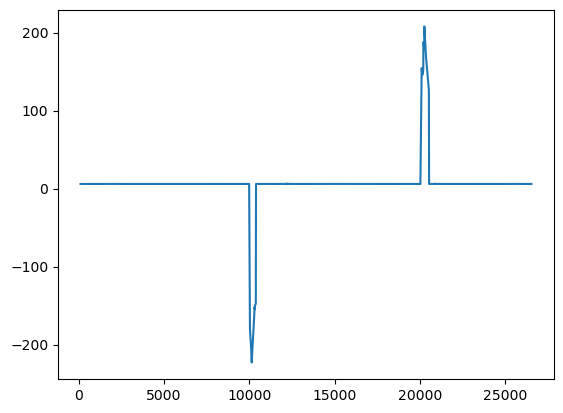

In [81]:
def rolling_metric_pace(duration, distance):
    return (duration.sum() / 60) / (distance.sum() / 1000)


x = df.cumulative_distance
y = rolling_apply(rolling_metric_pace, 10, df.duration.values, df.distance.values)

plt.plot(x, y)


